In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv('house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('house-prices/test.csv', index_col=['Id'])

## Започваме с най-добрия вече съществуващ модел

In [3]:
train.LotFrontage = train.LotFrontage.fillna(0)
train.GarageYrBlt = train.GarageYrBlt.fillna(0)
train.MasVnrArea = train.MasVnrArea.fillna(0)
train.SalePrice = pd.np.log10(train.SalePrice)

train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
train_sale_price = train['SalePrice']

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

numeric_column_names = train_no_sale_price.describe().columns
categorical_columns = train_no_sale_price.dtypes[train.dtypes == 'object'].index

categorical_data = train_no_sale_price[categorical_columns]
train_encoded = pd.DataFrame({
    c: LabelEncoder().fit(train.fillna('')[c]).transform(categorical_data[c].fillna("")) for c in categorical_columns
}, index = train_no_sale_price)
one_hot = OneHotEncoder().fit(train_encoded).transform(train_encoded)
new_train = pd.np.concatenate([one_hot.todense(), train_no_sale_price[numeric_column_names]], axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_train, train_sale_price, test_size=0.3, random_state=4330)

c:\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Започвам с най-добрия модел, който имам до момента, като опитвам малко повече стойности за регуляризация:

In [5]:
from sklearn.linear_model import Ridge 

for alpha in [0.1, 1, 10, 16, 18, 20, 100]:
    all_data_lr = Ridge(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  0.1 	train:  0.9432298317185679 	test:  0.9059958936362613
alpha:  1 	train:  0.9341947544847012 	test:  0.9186587324988607
alpha:  10 	train:  0.9145728136422795 	test:  0.9257768879730855
alpha:  16 	train:  0.9096253489993695 	test:  0.9263473343712055
alpha:  18 	train:  0.9083237836975386 	test:  0.9264065158513625
alpha:  20 	train:  0.9071364098202841 	test:  0.9264269122432969
alpha:  100 	train:  0.8856716730211226 	test:  0.9220580063440621


## Полиномиални фийчъри

Проверявам ефекта на interaction_only/include_bias при полиномиални фийчъри.

In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
poly_features.fit(x_train)

poly_x_train = poly_features.transform(x_train)
poly_x_test = poly_features.transform(x_test)

for alpha in [1e8, 3e8, 1e9, 3e9, 1e10]:
    all_data_lr = Ridge(alpha = alpha).fit(poly_x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(poly_x_train, y_train), '\ttest: ', all_data_lr.score(poly_x_test, y_test))

alpha:  100000000.0 	train:  0.9747149724983218 	test:  0.7567972989032823
alpha:  300000000.0 	train:  0.9680795761823215 	test:  0.8073733653678512
alpha:  1000000000.0 	train:  0.9601410489997864 	test:  0.8364709418616634
alpha:  3000000000.0 	train:  0.9517442536928292 	test:  0.8299192160431703
alpha:  10000000000.0 	train:  0.9404467503868039 	test:  0.8289598461070519


In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features.fit(x_train)

poly_x_train = poly_features.transform(x_train)
poly_x_test = poly_features.transform(x_test)

for alpha in [1e8, 3e8, 1e9, 3e9, 1e10]:
    all_data_lr = Ridge(alpha = alpha).fit(poly_x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(poly_x_train, y_train), '\ttest: ', all_data_lr.score(poly_x_test, y_test))

alpha:  100000000.0 	train:  0.9747149724247605 	test:  0.7567972982398783
alpha:  300000000.0 	train:  0.968079576167618 	test:  0.8073733627349434
alpha:  1000000000.0 	train:  0.9601410489891997 	test:  0.8364709426948647
alpha:  3000000000.0 	train:  0.9517442536921715 	test:  0.8299192170532036
alpha:  10000000000.0 	train:  0.9404467503880019 	test:  0.8289598459686898


Това е някакво подобрение спрямо 0.960607069631/0.828562611736 за train/test, който имахме първоначално. Но не е нещо твърде интересно. И отново има твърде голям overfit.

## Различни регресори

In [8]:
from sklearn.linear_model import Lars

for eps in [7e-1, 1e0, 2e0, 3e0, 3.5e0, 1e1]:
    all_data_lr = Lars(eps = eps).fit(x_train, y_train)
    print('eps: ', eps, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

eps:  0.7 	train:  0.9127421771189032 	test:  0.7931223278243249
eps:  1.0 	train:  0.9340935433866963 	test:  0.9174329965526588
eps:  2.0 	train:  0.8525053286837376 	test:  0.8595144936896678
eps:  3.0 	train:  0.7613599990739384 	test:  0.7691570830547869
eps:  3.5 	train:  0.7052564168865257 	test:  0.7124880951199382
eps:  10.0 	train:  0.23833760943642024 	test:  0.23979389223260672


In [9]:
from sklearn.linear_model import Lasso

for alpha in [8e-5, 1e-4, 2e-4, 3e-4, 1e-3, 3e-3, 1e-4]:
    all_data_lr = Lasso(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  8e-05 	train:  0.9369635666255196 	test:  0.9302729859505364
alpha:  0.0001 	train:  0.9351550368697275 	test:  0.9326338031183586
alpha:  0.0002 	train:  0.9274941743326026 	test:  0.9359127803504758
alpha:  0.0003 	train:  0.9193033582624983 	test:  0.9356786508952853
alpha:  0.001 	train:  0.8740302905123147 	test:  0.9200975796667462
alpha:  0.003 	train:  0.8435364687563569 	test:  0.9052268035848794
alpha:  0.0001 	train:  0.9351550368697275 	test:  0.9326338031183586


In [10]:
from sklearn.linear_model import ElasticNet

for alpha in [9e-5, 1e-4, 2e-4, 3e-4, 1e-3, 3e-3]:
    all_data_lr = ElasticNet(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  9e-05 	train:  0.939742084427589 	test:  0.9240280637962036
alpha:  0.0001 	train:  0.9391544059196337 	test:  0.925325044557522
alpha:  0.0002 	train:  0.9334244119219754 	test:  0.9323793393132636
alpha:  0.0003 	train:  0.9284926225667961 	test:  0.9338958730833364
alpha:  0.001 	train:  0.8974675049249836 	test:  0.9290918302337547
alpha:  0.003 	train:  0.8625519341519489 	test:  0.9139608214111532


In [11]:
from sklearn.linear_model import LassoLars

for alpha in [7e-5, 1e-4, 2e-4, 3e-4, 1e-3, 3e-3]:
    all_data_lr = LassoLars(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  7e-05 	train:  0.9239645610406987 	test:  0.9383000670669658
alpha:  0.0001 	train:  0.9164646900409252 	test:  0.9372579915902592
alpha:  0.0002 	train:  0.8937159122879127 	test:  0.9251091112735874
alpha:  0.0003 	train:  0.8671485150983096 	test:  0.9081293296299905
alpha:  0.001 	train:  0.730005015040027 	test:  0.7922240198277191
alpha:  0.003 	train:  0.33798456888310197 	test:  0.3642688054119195


Lasso дава някакво продобение.

## Feature engineering

Данните в `MSSubClass` изглежда са от числов тип, но семантично са етикети. Дистрибуцията би трябвало да е някакво глупост...

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


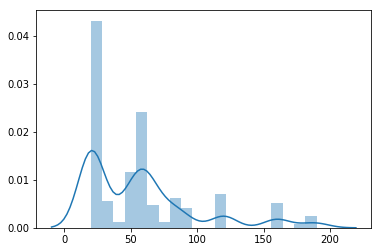

In [12]:
sns.distplot(tuple(train_no_sale_price.MSSubClass))

In [13]:
new_train = train_no_sale_price[numeric_column_names].copy()

for subclass in [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]:
    new_train['MSSubClass' + str(subclass)] = (train.MSSubClass == subclass).astype(float)
    
new_train.drop('MSSubClass', axis=1);

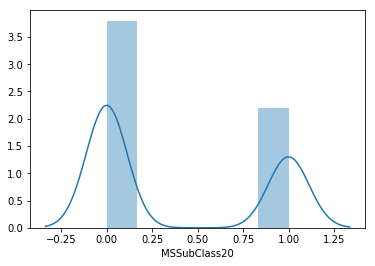

In [14]:
sns.distplot(new_train.MSSubClass20)

In [15]:
new_train = pd.np.concatenate([one_hot.todense(), new_train], axis=1)

x_train, x_test, y_train, y_test = train_test_split(new_train, train_sale_price, test_size=0.3, random_state=4330)

In [16]:
from sklearn.linear_model import Lasso

for alpha in [8e-5, 1e-4, 2e-4, 3e-4, 1e-3, 3e-3, 1e-4]:
    all_data_lr = Lasso(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  8e-05 	train:  0.9383374553463935 	test:  0.9313227662728075
alpha:  0.0001 	train:  0.9364632452619412 	test:  0.9341233165031287
alpha:  0.0002 	train:  0.9289023944462712 	test:  0.9372037527122234
alpha:  0.0003 	train:  0.9204827310422425 	test:  0.9366651398355403
alpha:  0.001 	train:  0.8746595448078333 	test:  0.9202861135769224
alpha:  0.003 	train:  0.8435364756965794 	test:  0.905226811993877
alpha:  0.0001 	train:  0.9364632452619412 	test:  0.9341233165031287


In [18]:
from sklearn.linear_model import LassoLars

for alpha in [9e-5, 1e-4, 2e-4, 3e-4]:
    all_data_lr = LassoLars(alpha = alpha).fit(x_train, y_train)
    print('alpha: ', alpha, '\ttrain: ', all_data_lr.score(x_train, y_train), '\ttest: ', all_data_lr.score(x_test, y_test))

alpha:  9e-05 	train:  0.9196087656909153 	test:  0.938804094838236
alpha:  0.0001 	train:  0.9172506227888085 	test:  0.9380534876231266
alpha:  0.0002 	train:  0.8942452653724698 	test:  0.9255399729540554
alpha:  0.0003 	train:  0.8676411463108582 	test:  0.9084135232198125


Това изглежда разумно:
```
alpha:  9e-05 	train:  0.9196087656909153 	test:  0.938804094838236
```

## Допълнително

Позанимавах се да направя всички наредени данни на числа и да ги прекарам през `RandomForestRegressor` (без `OneHotEncoder`). Резултатите не бяха впечатляващи. За съжаление ми умря зарядното на лаптопа и няма да мога да покажа резултати. Пък при положение че не са по-добри - май няма и много смисъл.